# Testing des Models 

Version updated: 01.08.2019 (latest version)

In [2]:
from pyntcloud import PyntCloud
import os
import numpy as np
from random import randint, uniform
import pandas as pd
import tensorflow as tf
from tensorflow.python.keras.callbacks import TensorBoard
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Visualize the test data
import scipy.io as io
import scipy.ndimage as nd

import pyrealsense2 as rs

# Restore the trained model
model = tf.keras.models.load_model('savedmodel/k_model_Washington.h5')



def save_to_ply(): 
    
    # Wait for the next set of frames from the camera
    frames = pipe.wait_for_frames()

    # Fetch color and depth frames
    depth = frames.get_depth_frame()
    color = frames.get_color_frame()

    # Tell pointcloud object to map to this color frame
    pc.map_to(color)

    # Generate the pointcloud and texture mappings
    points = pc.calculate(depth)

    print("Saving to 1.ply...")
    points.export_to_ply("data/rs_ply_files/1.ply", color)
    print("Done")


In [3]:

# ---------------------------------------------------> Camera Setup <---------------------------------------------------

DS5_product_ids = ["0AD1", "0AD2", "0AD3", "0AD4", "0AD5", "0AF6", "0AFE", "0AFF", "0B00", "0B01", "0B03", "0B07","0B3A"]

def find_device_that_supports_advanced_mode() :
    ctx = rs.context()
    ds5_dev = rs.device()
    devices = ctx.query_devices();
    for dev in devices:
        if dev.supports(rs.camera_info.product_id) and str(dev.get_info(rs.camera_info.product_id)) in DS5_product_ids:
            if dev.supports(rs.camera_info.name):
                print("Found device that supports advanced mode:", dev.get_info(rs.camera_info.name))
            return dev
    raise Exception("No device that supports advanced mode was found")



dev = find_device_that_supports_advanced_mode()
device= rs.context().query_devices()[0]
advnc_mode = rs.rs400_advanced_mode(dev)
depth_table_control_group = advnc_mode.get_depth_table()
depth_table_control_group.disparityShift =128
advnc_mode.set_depth_table(depth_table_control_group)

# Declare pointcloud object, for calculating pointclouds and texture mappings
pc = rs.pointcloud()
# We want the points object to be persistent so we can display the last cloud when a frame drops
points = rs.points()

# Declare RealSense pipeline, encapsulating the actual device and sensors
pipe = rs.pipeline()
#Start streaming with default recommended configuration
pipe.start()


try:
    #save_to_ply()
finally:
    
    pipe.stop()

Found device that supports advanced mode: Intel RealSense D415
Saving to 1.ply...
Done


In [7]:
import math
import time
import cv2
import numpy as np
import pyrealsense2 as rs


class AppState:

    def __init__(self, *args, **kwargs):
        self.WIN_NAME = 'RealSense'
        self.pitch, self.yaw = math.radians(-10), math.radians(-15)
        self.translation = np.array([0, 0, -1], dtype=np.float32)
        self.distance = 2
        self.prev_mouse = 0, 0
        self.mouse_btns = [False, False, False]
        self.paused = False
        self.decimate = 1
        self.scale = True
        self.color = True

    def reset(self):
        self.pitch, self.yaw, self.distance = 0, 0, 2
        self.translation[:] = 0, 0, -1

    @property
    def rotation(self):
        Rx, _ = cv2.Rodrigues((self.pitch, 0, 0))
        Ry, _ = cv2.Rodrigues((0, self.yaw, 0))
        return np.dot(Ry, Rx).astype(np.float32)

    @property
    def pivot(self):
        return self.translation + np.array((0, 0, self.distance), dtype=np.float32)


state = AppState()

# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

# Start streaming
pipeline.start(config)

# Get stream profile and camera intrinsics
profile = pipeline.get_active_profile()
depth_profile = rs.video_stream_profile(profile.get_stream(rs.stream.depth))
depth_intrinsics = depth_profile.get_intrinsics()
w, h = depth_intrinsics.width, depth_intrinsics.height

# Processing blocks
pc = rs.pointcloud()
decimate = rs.decimation_filter()
decimate.set_option(rs.option.filter_magnitude, 2 ** state.decimate)
colorizer = rs.colorizer()


def mouse_cb(event, x, y, flags, param):

    if event == cv2.EVENT_LBUTTONDOWN:
        state.mouse_btns[0] = True

    if event == cv2.EVENT_LBUTTONUP:
        state.mouse_btns[0] = False

    if event == cv2.EVENT_RBUTTONDOWN:
        state.mouse_btns[1] = True

    if event == cv2.EVENT_RBUTTONUP:
        state.mouse_btns[1] = False

    if event == cv2.EVENT_MBUTTONDOWN:
        state.mouse_btns[2] = True

    if event == cv2.EVENT_MBUTTONUP:
        state.mouse_btns[2] = False

    if event == cv2.EVENT_MOUSEMOVE:

        h, w = out.shape[:2]
        dx, dy = x - state.prev_mouse[0], y - state.prev_mouse[1]

        if state.mouse_btns[0]:
            state.yaw += float(dx) / w * 2
            state.pitch -= float(dy) / h * 2

        elif state.mouse_btns[1]:
            dp = np.array((dx / w, dy / h, 0), dtype=np.float32)
            state.translation -= np.dot(state.rotation, dp)

        elif state.mouse_btns[2]:
            dz = math.sqrt(dx**2 + dy**2) * math.copysign(0.01, -dy)
            state.translation[2] += dz
            state.distance -= dz

    if event == cv2.EVENT_MOUSEWHEEL:
        dz = math.copysign(0.1, flags)
        state.translation[2] += dz
        state.distance -= dz

    state.prev_mouse = (x, y)


cv2.namedWindow(state.WIN_NAME, cv2.WINDOW_AUTOSIZE)
cv2.resizeWindow(state.WIN_NAME, w, h)
cv2.setMouseCallback(state.WIN_NAME, mouse_cb)


def project(v):
    """project 3d vector array to 2d"""
    h, w = out.shape[:2]
    view_aspect = float(h)/w

    # ignore divide by zero for invalid depth
    with np.errstate(divide='ignore', invalid='ignore'):
        proj = v[:, :-1] / v[:, -1, np.newaxis] * \
            (w*view_aspect, h) + (w/2.0, h/2.0)

    # near clipping
    znear = 0.03
    proj[v[:, 2] < znear] = np.nan
    return proj


def view(v):
    """apply view transformation on vector array"""
    return np.dot(v - state.pivot, state.rotation) + state.pivot - state.translation


def line3d(out, pt1, pt2, color=(0x80, 0x80, 0x80), thickness=1):
    """draw a 3d line from pt1 to pt2"""
    p0 = project(pt1.reshape(-1, 3))[0]
    p1 = project(pt2.reshape(-1, 3))[0]
    if np.isnan(p0).any() or np.isnan(p1).any():
        return
    p0 = tuple(p0.astype(int))
    p1 = tuple(p1.astype(int))
    rect = (0, 0, out.shape[1], out.shape[0])
    inside, p0, p1 = cv2.clipLine(rect, p0, p1)
    if inside:
        cv2.line(out, p0, p1, color, thickness, cv2.LINE_AA)


def grid(out, pos, rotation=np.eye(3), size=1, n=10, color=(0x80, 0x80, 0x80)):
    """draw a grid on xz plane"""
    pos = np.array(pos)
    s = size / float(n)
    s2 = 0.5 * size
    for i in range(0, n+1):
        x = -s2 + i*s
        line3d(out, view(pos + np.dot((x, 0, -s2), rotation)),
               view(pos + np.dot((x, 0, s2), rotation)), color)
    for i in range(0, n+1):
        z = -s2 + i*s
        line3d(out, view(pos + np.dot((-s2, 0, z), rotation)),
               view(pos + np.dot((s2, 0, z), rotation)), color)


def axes(out, pos, rotation=np.eye(3), size=0.075, thickness=2):
    """draw 3d axes"""
    line3d(out, pos, pos +
           np.dot((0, 0, size), rotation), (0xff, 0, 0), thickness)
    line3d(out, pos, pos +
           np.dot((0, size, 0), rotation), (0, 0xff, 0), thickness)
    line3d(out, pos, pos +
           np.dot((size, 0, 0), rotation), (0, 0, 0xff), thickness)


def frustum(out, intrinsics, color=(0x40, 0x40, 0x40)):
    """draw camera's frustum"""
    orig = view([0, 0, 0])
    w, h = intrinsics.width, intrinsics.height

    for d in range(1, 6, 2):
        def get_point(x, y):
            p = rs.rs2_deproject_pixel_to_point(intrinsics, [x, y], d)
            line3d(out, orig, view(p), color)
            return p

        top_left = get_point(0, 0)
        top_right = get_point(w, 0)
        bottom_right = get_point(w, h)
        bottom_left = get_point(0, h)

        line3d(out, view(top_left), view(top_right), color)
        line3d(out, view(top_right), view(bottom_right), color)
        line3d(out, view(bottom_right), view(bottom_left), color)
        line3d(out, view(bottom_left), view(top_left), color)


def pointcloud(out, verts, texcoords, color, painter=True):
    """draw point cloud with optional painter's algorithm"""
    if painter:
        # Painter's algo, sort points from back to front

        # get reverse sorted indices by z (in view-space)
        # https://gist.github.com/stevenvo/e3dad127598842459b68
        v = view(verts)
        s = v[:, 2].argsort()[::-1]
        proj = project(v[s])
    else:
        proj = project(view(verts))

    if state.scale:
        proj *= 0.5**state.decimate

    h, w = out.shape[:2]

    # proj now contains 2d image coordinates
    j, i = proj.astype(np.uint32).T

    # create a mask to ignore out-of-bound indices
    im = (i >= 0) & (i < h)
    jm = (j >= 0) & (j < w)
    m = im & jm

    cw, ch = color.shape[:2][::-1]
    if painter:
        # sort texcoord with same indices as above
        # texcoords are [0..1] and relative to top-left pixel corner,
        # multiply by size and add 0.5 to center
        v, u = (texcoords[s] * (cw, ch) + 0.5).astype(np.uint32).T
    else:
        v, u = (texcoords * (cw, ch) + 0.5).astype(np.uint32).T
    # clip texcoords to image
    np.clip(u, 0, ch-1, out=u)
    np.clip(v, 0, cw-1, out=v)

    # perform uv-mapping
    out[i[m], j[m]] = color[u[m], v[m]]


out = np.empty((h, w, 3), dtype=np.uint8)

while True:
    # Grab camera data
    if not state.paused:
        # Wait for a coherent pair of frames: depth and color
        frames = pipeline.wait_for_frames()

        depth_frame = frames.get_depth_frame()
        color_frame = frames.get_color_frame()

        depth_frame = decimate.process(depth_frame)

        # Grab new intrinsics (may be changed by decimation)
        depth_intrinsics = rs.video_stream_profile(
            depth_frame.profile).get_intrinsics()
        w, h = depth_intrinsics.width, depth_intrinsics.height

        depth_image = np.asanyarray(depth_frame.get_data())
        color_image = np.asanyarray(color_frame.get_data())

        depth_colormap = np.asanyarray(
            colorizer.colorize(depth_frame).get_data())

        if state.color:
            mapped_frame, color_source = color_frame, color_image
        else:
            mapped_frame, color_source = depth_frame, depth_colormap

        points = pc.calculate(depth_frame)
        pc.map_to(mapped_frame)

        # Pointcloud data to arrays
        v, t = points.get_vertices(), points.get_texture_coordinates()
        verts = np.asanyarray(v).view(np.float32).reshape(-1, 3)  # xyz
        texcoords = np.asanyarray(t).view(np.float32).reshape(-1, 2)  # uv

    # Render
    now = time.time()

    out.fill(0)

    grid(out, (0, 0.5, 1), size=1, n=10)
    frustum(out, depth_intrinsics)
    axes(out, view([0, 0, 0]), state.rotation, size=0.1, thickness=1)

    if not state.scale or out.shape[:2] == (h, w):
        pointcloud(out, verts, texcoords, color_source)
    else:
        tmp = np.zeros((h, w, 3), dtype=np.uint8)
        pointcloud(tmp, verts, texcoords, color_source)
        tmp = cv2.resize(
            tmp, out.shape[:2][::-1], interpolation=cv2.INTER_NEAREST)
        np.putmask(out, tmp > 0, tmp)

    if any(state.mouse_btns):
        axes(out, view(state.pivot), state.rotation, thickness=4)

    dt = time.time() - now

    cv2.setWindowTitle(
        state.WIN_NAME, "RealSense (%dx%d) %dFPS (%.2fms) %s" %
        (w, h, 1.0/dt, dt*1000, "PAUSED" if state.paused else ""))

    cv2.imshow(state.WIN_NAME, out)
    key = cv2.waitKey(1)

    if key == ord("r"):
        state.reset()

    if key == ord("p"):
        state.paused ^= True

    if key == ord("d"):
        state.decimate = (state.decimate + 1) % 3
        decimate.set_option(rs.option.filter_magnitude, 2 ** state.decimate)

    if key == ord("z"):
        state.scale ^= True

    if key == ord("c"):
        state.color ^= True

    if key == ord("s"):
        cv2.imwrite('./out.png', out)

    if key == ord("e"):
        points.export_to_ply('./out.ply', mapped_frame)

    if key in (27, ord("q")) or cv2.getWindowProperty(state.WIN_NAME, cv2.WND_PROP_AUTOSIZE) < 0:
        break

# Stop streaming
pipeline.stop()

In [8]:

# Load RealSense .PLY Data to PyntCloud Object
pointcloud = PyntCloud.from_file("out.ply") 
#pointcloud = pointcloud.get_sample("mesh_random", n=50000, rgb=True, normals=False, as_PyntCloud=True)

In [9]:
scene = pointcloud.plot(initial_point_size=0.001)

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.008038532920181751, 0.08764275815337896, …

In [10]:

# ------------------------------------------ Voxilisation -----------------------------------------------------

# create Voxelgrid from Pointcloudscene
voxelgrid_id = pointcloud.add_structure("voxelgrid", n_x=128, n_y=128, n_z=128)
voxelscene = pointcloud.structures[voxelgrid_id]

# Create binary array from Voxelscene 
binary_voxelscene = voxelscene.get_feature_vector(mode="binary")

voxelscene.plot(d=3, mode="density", cmap="hsv")


In [12]:
# Prepare data for Network input
binary_voxelscene = np.expand_dims(binary_voxelscene, axis=0)
print(binary_voxelscene.shape)

# Classification Output on Testvoxels
cnn_out = model.predict(binary_voxelscene)

cnn_prediction = np.argmax(cnn_out)

print("Predicted Numbers of Objects:", cnn_prediction)

(1, 1, 128, 128, 128)


ValueError: Error when checking input: expected reshape_input to have 4 dimensions, but got array with shape (1, 1, 128, 128, 128)

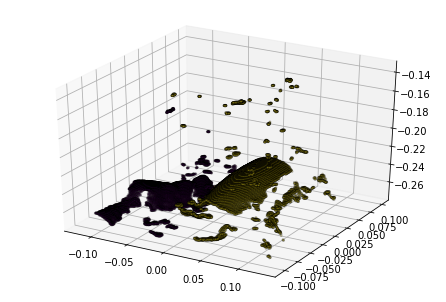

In [21]:
# ----------------------------------------------- K Means Clustering --------------------------------------------------

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = cnn_prediction, init='k-means++')

#pointcloud = pointcloud.xyz

kmeans = kmeans.fit(pointcloud)
labels = kmeans.predict(pointcloud)
centroids = kmeans.cluster_centers_

fig = plt.figure()
ax = Axes3D(fig)
pe = ax.scatter(pointcloud[:, 0], pointcloud[:, 1], pointcloud[:, 2], c=labels, cmap='viridis',
            edgecolor='k', s=3, alpha = 0.3)

In [32]:
print(labels.size)

28108


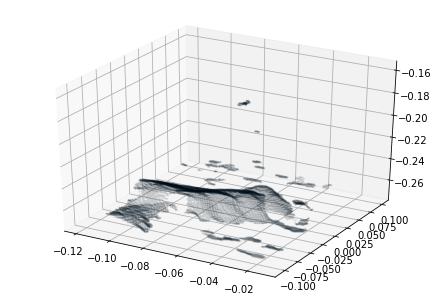

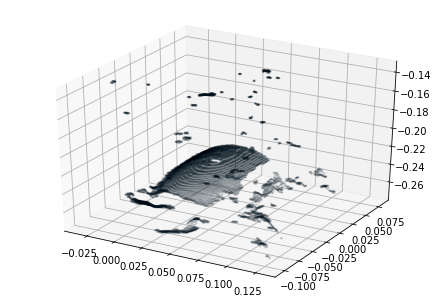

In [30]:
# ----------------------------------- Evaluation of Clustering ----------------------------------------------------

clusters_dict = {i: pointcloud[np.where(labels == i)[0]] for i in range(kmeans.n_clusters)}

#  dictionary to list 
clusters_list = []
for key, value in clusters_dict.items():
    temp = [key,value]
    clusters_list.append(temp)
    
# Plotten der einzelnen Cluster    
for i in range(kmeans.n_clusters):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(clusters_dict[i][:,0], clusters_dict[i][:, 1], clusters_dict[i][:, 2], 
               cmap='viridis',edgecolor='k', s=1, alpha = 0.1)

In [ ]:
# ---------------------  Verteilung der Punkte/Cluster zu Punkte/Original PC -------------------------------------------

c = 0   # Counter for Clusters
p = 0   # Counter for Pointclouds
counter = 0     # Counter for matches between Pointclouds and Clusters
allocation_list = np.zeros((3, 3), dtype=int)

''' 
Structure of allocation list

    p0  p1  p2 ...
c0
c1 
c2
...
'''

while c < 3:

    for Pj in clusters_dict[c]:
        for Pi in labeled_pointcloudscene[p]:
            if np.all(Pj == Pi):
                counter = counter + 1

    allocation_list[c, p] = counter
    p = p + 1
    counter = 0

    if p > cnn_prediction:  # max anzahl an pointclouds rounded_cnn
        c = c + 1
        p = 0
    else:
       continue

print(allocation_list)

In [ ]:
allocation_max = np.amax(allocation_list, axis=1)
x = 0
y = 0
allocation_result={}

'''
    returns allocation between Clusters/ PClouds like: (Clusternumber,Pointcloudnumber), ...
    --> Prediction based of where is the max Value 
'''

while y <= (len(allocation_max) - 1):  # len q = 3 but we start at 0 
    
    result = (np.where(allocation_list[y] == allocation_max[y]))
    allocation_result[y] =  y , result[0][0]
    print("Cluster",y,"belongs to", "Pointcloud",result[0][0])
    y = y + 1 

allocation_result

In [ ]:
i = 0 
score = {}
temp = 0
max_value = np.amax(allocation_list)

# Calculates for every existing Cluster the score
while i <= 2:
    for d in allocation_list[i]:  
        if (d > 0) and (d < allocation_max[i]):  # d > 0 < clusters maxvalue
            temp = 0
            temp = temp + d
        elif (d > 0) and (d < max_value): # d > 0 < overall max value in allocation list
            temp = 0
            temp = temp + (max_value - d)
        score[i] = temp
    print("Cluster",i, "score=", score[i])

    i = i + 1
    
score